The code might be more detailed if I looked at momental R_G like I do with Mdot_G, though this might not be worth the longer runtime.

# Packages

In [1]:
import os, sys
import numpy as np
import h5py as h5

import astropy.constants as c
import astropy.units as u
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.interpolate import interpn

from IPython.display import clear_output
import time

from scipy.interpolate import LinearNDInterpolator

# Importing data

Defining the paths to the data

In [2]:
path = '/STER/axelf/'  # Base directory for storing all files

# Define paths to different categories of data
path_data = path + 'simulations/'
path_energy = path_data + 'classic/'
path_twostage = path_data + 'twostage/'
path_unstable = path_data + 'unstable/'
path_stable = path_data + 'stable/'

# Define the path for observed data
path_obs = path + 'observations/'

Loading the data

In [3]:
# Load observed periods data
periods_obs = np.loadtxt(path_obs + '/periods.txt')

Loading forced stable MT data for the different values of $\gamma$ = {0,0.5,1} and $\beta$ = {0,0.1,0.2,0.3,0.4,0.5}

In [4]:
dataStables = []  # List to store data files for stable simulations
paramsStable = []  # List to store parameter sets (beta, gamma) for stable simulations

# Define gamma values and beta values range
gamma_values = [0.0, 0.5, 1.0]  # Specific gamma values to iterate over
beta_values = np.linspace(0.0, 1, 6)  # Beta values ranging from 0 to 1 in 6 steps

# Loop over different values of gamma and beta to load the corresponding simulation data
for g in gamma_values:  # Iterate over specified gamma values
    for b in beta_values:  # Iterate over beta values
                
        # Append the (beta, gamma) parameter pair to the paramsStable list
        paramsStable.append([b, g])
        
        # Construct the file path using formatted strings for clarity
        file_path = path_stable + "gamma_" + str(g) + "/beta_" + str(np.around(b,1)) + "/output_1/COMPAS_Output.h5"
        
        # Load the simulation data file (.h5 format) for the current beta and gamma
        dataStables.append(h5.File(file_path, 'r'))  # 'r' mode for read access


Loading classical MT data with $\alpha_{CE}$ = {$10^{-1}, 10^{-0.5}, 10^{0}, 10^{0.5}, 10^1$}

In [5]:
# Initialize a list to store energy data files
dataEnergys = []  # List to store data files for energy simulations

# Define the range of energy parameter values
energy_values = [-1, -0.5, 0, 0.5, 1]  # Specific energy parameter values

# Loop over specified energy parameter values to load corresponding simulation data
for energy in energy_values:
    # Construct the file path using formatted strings for clarity
    file_path = path_energy + "output_" + str(energy) +"_1/COMPAS_Output.h5"
    
    # Load the simulation data file (.h5 format) for the current energy value
    dataEnergys.append(h5.File(file_path, 'r'))  # 'r' mode for read access

Loading forced unstable MT data with $\alpha_{CE}$ = {$10^{-1}, 10^{-0.5}, 10^{0}, 10^{0.5}, 10^1$}

In [6]:
# Initialize a list to store energy data files
dataUnstables = []  # List to store data files for energy simulations

# Loop over specified energy parameter values to load corresponding simulation data
for energy in energy_values:
    # Construct the file path using formatted strings for clarity
    file_path = path_unstable + "output_" + str(energy) +"_1/COMPAS_Output.h5"
    
    # Load the simulation data file (.h5 format) for the current energy value
    dataUnstables.append(h5.File(file_path, 'r'))  # 'r' mode for read access

Loading two-stage CE phase data which doesn't have free parameters 

In [7]:
# Load two-stage simulation data
data2Stage = h5.File(path_twostage + "output_1/COMPAS_Output.h5", 'r')  # Load two-stage data file

# Wind implementation

## Wind loss interpolation

Because the massloss of a giant changes drastically during its evolution, we will use a grid of single evolved giants to interpolate an approximate massloss at that point of the stars evolution.

In [8]:
# Grids of giants for different phases
# Each grid consists of the giant mass at the beginning of the phase, total duration of its giantphase
# and a list of masslosses evenly spaced between 0% of total duration to 100% of total duration in steps of 1%

RGB_grid_inter = pd.read_pickle('RGB_grid_inter')
HeB_grid_inter = pd.read_pickle('HeB_grid_inter')
AGB_grid_inter = pd.read_pickle('AGB_grid_inter')

tpAGB_grid_inter = pd.read_pickle('tpAGB_grid_inter')

Since XXX_grid_inter\['Mdot'\] is a list of lists we want an array of array (or at least at one point we wanted this). This might not be very efficient but it doesn't take that long and it only has to be done once so I won't put any more time in it.

In [9]:
RGB_Mdots = []
for i in range(len(RGB_grid_inter['Mdot'])):
    
    RGB_Mdots.append(np.array(RGB_grid_inter['Mdot'][i]))
    
RGB_Mdots = np.array(RGB_Mdots)
RGB_Mass0 = np.array(RGB_grid_inter['Mass0'])

In [10]:
HeB_Mdots = []
for i in range(len(HeB_grid_inter['Mdot'])):
    
    HeB_Mdots.append(np.array(HeB_grid_inter['Mdot'][i]))
    
HeB_Mdots = np.array(HeB_Mdots)
HeB_Mass0 = np.array(HeB_grid_inter['Mass0'])

In [11]:
AGB_Mdots = []
for i in range(len(AGB_grid_inter['Mdot'])):
    
    AGB_Mdots.append(np.array(AGB_grid_inter['Mdot'][i]))
    
AGB_Mdots = np.array(AGB_Mdots)
AGB_Mass0 = np.array(AGB_grid_inter['Mass0'])

In [12]:
tpAGB_Mdots = []
for i in range(len(tpAGB_grid_inter['Mdot'])):
    
    tpAGB_Mdots.append(np.array(tpAGB_grid_inter['Mdot'][i]))
    
tpAGB_Mdots = np.array(tpAGB_Mdots)
tpAGB_Mass0 = np.array(tpAGB_grid_inter['Mass0'])

The next function gives the approximate massloss interpolated from the single giant evolution grids. M_G is the mass at the beginning of the giant phase.

The Types are:
- RGB: 3
- He-burning: 4
- AGB: 5
- Thermal pulsating AGB: 6

By subtracting 3 we can use this as indices for \[RGB,HeB,AGB,tpAGB\].

ALL_grid_Mass0 and ALL_grid_TimeTot are arrays that containt an array of Mass0/TimeTot for each systems depending on the stage it is in. This is very space inefficient but it is quite quick. We cannot do this for the Mdot as the dimensions of this require incredibly large memory. 

ALL_grid_Mdot instead holds the 4 arrays of Mdot from which the system can choose. This is then looped over for each system for each timestep (because np.interp does not work with multiple dimensions and I didn't really understand how to use the other functions). This is the largest (or actually smallest) bottleneck, so by optimizing this a lot of time could be saved.

In [13]:
RGB_Mass0 = np.array(RGB_grid_inter['Mass0'])
RGB_TimeTot = np.array(RGB_grid_inter['TimeTot'])
RGB_stages = np.linspace(0,1,101)

RGB_stage_mesh, RGB_Mass_mesh = np.meshgrid(RGB_stages, RGB_Mass0)


Mdots_RGB_interp = LinearNDInterpolator(list(zip(RGB_stage_mesh.flatten(), RGB_Mass_mesh.flatten())), RGB_Mdots.flatten())

In [14]:
HeB_Mass0 = np.array(HeB_grid_inter['Mass0'])
HeB_TimeTot = np.array(HeB_grid_inter['TimeTot'])
HeB_stages = np.linspace(0,1,101)

HeB_stage_mesh, HeB_Mass_mesh = np.meshgrid(HeB_stages, HeB_Mass0)


Mdots_HeB_interp = LinearNDInterpolator(list(zip(HeB_stage_mesh.flatten(), HeB_Mass_mesh.flatten())), HeB_Mdots.flatten())

In [15]:
AGB_Mass0 = np.array(AGB_grid_inter['Mass0'])
AGB_TimeTot = np.array(AGB_grid_inter['TimeTot'])
AGB_stages = np.linspace(0,1,101)

AGB_stage_mesh, AGB_Mass_mesh = np.meshgrid(AGB_stages, AGB_Mass0)


Mdots_AGB_interp = LinearNDInterpolator(list(zip(AGB_stage_mesh.flatten(), AGB_Mass_mesh.flatten())), AGB_Mdots.flatten())

In [16]:
tpAGB_Mass0 = np.array(tpAGB_grid_inter['Mass0'])
tpAGB_TimeTot = np.array(tpAGB_grid_inter['TimeTot'])
tpAGB_stages = np.linspace(0,1,101)

tpAGB_stage_mesh, tpAGB_Mass_mesh = np.meshgrid(tpAGB_stages, tpAGB_Mass0)


Mdots_tpAGB_interp = LinearNDInterpolator(list(zip(tpAGB_stage_mesh.flatten(), tpAGB_Mass_mesh.flatten())), tpAGB_Mdots.flatten())

In [17]:
Mdots_RGB_interp(0.5,5)

array(3.57798288e-09)

In [18]:
def interpWindLossALL_t(Type_G, M_G, t):
        
    ALL_grid_Mass0 = np.array([np.array(RGB_grid_inter['Mass0']), np.array(HeB_grid_inter['Mass0']), np.array(AGB_grid_inter['Mass0']), np.array(tpAGB_grid_inter['Mass0'])])[Type_G - 3]
    ALL_grid_TimeTot = np.array([np.array(RGB_grid_inter['TimeTot']), np.array(HeB_grid_inter['TimeTot']), np.array(AGB_grid_inter['TimeTot']), np.array(tpAGB_grid_inter['TimeTot'])])[Type_G - 3]
        
    ############################
    
    TimeTot_RGB = np.interp(M_G.to(u.Msun).value, RGB_Mass0, RGB_TimeTot)
    TimeTot_HeB = np.interp(M_G.to(u.Msun).value, HeB_Mass0, HeB_TimeTot)
    TimeTot_AGB = np.interp(M_G.to(u.Msun).value, AGB_Mass0, AGB_TimeTot)
    TimeTot_tpAGB = np.interp(M_G.to(u.Msun).value, tpAGB_Mass0, tpAGB_TimeTot)
    
    TimeTot_all = np.array([TimeTot_RGB,TimeTot_HeB,TimeTot_AGB,TimeTot_tpAGB])
    
    TimeTot_G = TimeTot_all[Type_G - 3, np.arange(len(M_G))] * u.Myr
            
    ############################

    stage = (t/TimeTot_G).to(1).value
            
    stage[stage > 1] = 1
        
    ############################
    
    Mdots_RGB = Mdots_RGB_interp(stage,M_G)
    
    ############################

    Mdots_HeB = Mdots_HeB_interp(stage,M_G)
    
    ############################

    Mdots_AGB = Mdots_AGB_interp(stage,M_G)
    
    ############################

    Mdots_tpAGB = Mdots_tpAGB_interp(stage,M_G)
    
    ############################
    
    Mdots_all = np.array([Mdots_RGB,Mdots_HeB,Mdots_AGB,Mdots_tpAGB])
    
    ############################

    Mdots = Mdots_all[Type_G - 3, :, np.arange(len(M_G))]    
    
    return Mdots * u.Msun / u.yr

## Accretion rate

Mdot_acc is the accretion rate of stellar wind from \[Bondi & Hoyle et al. (1944)\]. From all the mass that is accreted not all is accumulated (due to winds from the WD), the factor of accreted mass that is also accumulated is called the accumulation factor $\alpha_H$.

In [19]:
# accretion rate
def Mdot_acc(M_WD, a, v_orb, Mdot_G, R_G, M_G):

    # for circles r = a, used in v_w
    
    vw = v_w(a, R_G, M_G)
    
    eps = 3/2
    v = v_orb / vw
    
    Mdot_WD = (c.G * M_WD / vw**2) **2 * (eps / (2 * a**2)) / (1 + v**2)**(3/2) * Mdot_G
    
    return Mdot_WD.to(u.Msun / u.yr) # Msun yr^-1

# accumulation rate
def Mdot_accum(Mdotacc, M_WD):

    alpha = alpha_H(Mdotacc, M_WD)
        
    Mdotaccum = alpha * Mdotacc
    
    return Mdotaccum.to(u.Msun / u.yr) # Msun yr^-1

The next block is all about calculating the wind velocity. For v_inf we use 1/2 v_esc, I don't know whether is a common choice or whether this should be cited from somewhere (I took it from \[Lu et al (2006)\]). \[YLTK (1995)\] defined the wind velocity as $v_w = \alpha_w v_\infty$. \[Lü et al.\] also mention another (empirical) formula for $\alpha_w$.

In [20]:
def v_w(r, R_G, M_G):
    
    return (alpha_w(r, R_G) * v_inf(M_G, R_G)).to(u.km / u.s)

def alpha_w(r, R_d):
    
    return (0.04 * (r/R_d)**2 / (1 + 0.04 * (r/R_d)**2)).to(1)

def v_inf(M, R):
    
    return (1/2 * v_esc(M, R)).to(u.km / u.s)

def v_esc(M, R):
    
    return np.sqrt(2 * c.G * M / R).to(u.km / u.s)

## Accumulation Efficiency

The $accretion$-rate at which the WD will have stable H-burning is Mdot_st \[Iben & Tutukov (1989)\]. The accumulation effeciency of the WD is never gonna be 100%. The fraction of accreted mass accumulated depends of the mass and accretion rate of the WD. The boundary between strong abd weaj SyNe is the Mdot_ws \[Yaron et al. (2005)\]. Above this rate (but below Mdot_st) we have weak SyNe, and below this we have strong SyNe.

In [21]:
# is this correct?
def Mdot_st(M_WD):
    
    return 10**( -9.31 + 4.12 * M_WD.to(u.Msun).value -1.42 * (M_WD.to(u.Msun).value)**2 ) * u.Msun / u.yr

def Mdot_ws(M_WD):
            
    Mdot_ws_low  = 10**(-11.01 + 6 * M_WD.to(u.Msun).value - 1.90 * (M_WD.to(u.Msun).value)**2) * u.Msun / u.yr
    
    Mdot_ws_high = np.ones(len(M_WD)) * 10**(-7.0) * u.Msun / u.yr
    
    Mdot_ws_both = np.array([Mdot_ws_low, Mdot_ws_high])
    
    Mdot_ws_ind = (M_WD <= 1 * u.Msun) + 0
    
    Mdot = np.zeros(len(M_WD))
    
    for i in range(len(M_WD)):
        Mdot[i] = Mdot_ws_both[Mdot_ws_ind[i],i]
        
    return Mdot * u.Msun / u.yr

In [22]:
# normally we need the efficiency alpha that depends on weak/strong
def isStable(M_WD, Mdot_acc):
        
    return Mdot_acc > Mdot_st(M_WD)
    
def isWeak(M_WD, Mdot_acc):
    
    return Mdot_acc > Mdot_ws(M_WD)

The difference between weak and strong SyNe is the accumulation efficiency. For weak \[Iben & Tutukov (1996)\], for strong \[Lü et al\] based on data of \[Yaron et al. (2005)\].

In [23]:
# Accumulation efficiency

def alpha_H(Mdot_acc, M_WD):
    
    alphas_weak   = alpha_H_weak(Mdot_acc)
    alphas_strong = alpha_H_strong(M_WD)

    alphas_both = np.array([alphas_strong, alphas_weak])
    
    alphas_H = np.zeros(len(Mdot_acc))
        
    alpha_both_ind = isWeak(M_WD, Mdot_acc) + 0 # weak get index 1 and strong index 0 (True + 0 = 1, False + 0 = 0)
        
    for i in range(len(Mdot_acc)):
        alphas_H[i] = alphas_both[alpha_both_ind[i],i]
    
    return alphas_H


def alpha_H_weak(Mdot_acc):
    
    log_Mdot = np.log10(Mdot_acc.to(u.Msun / u.yr).value)
    
    alpha_low  = (-4.39 - 1.48 * log_Mdot - 0.1  * log_Mdot**2)
    alpha_high = (11.66 + 4.56 * log_Mdot + 0.45 * log_Mdot**2)
    
    alpha_both = np.array([alpha_low, alpha_high])
    
    #possibly quite slow
    alphas = np.zeros(len(Mdot_acc))

    alpha_both_ind = (log_Mdot >= -6.36) + 0
    
    for i in range(len(Mdot_acc)):
        alphas[i] = alpha_both[alpha_both_ind[i],i]
    
    return alphas
    
def alpha_H_strong(M_WD):
    
    return (-0.1391 + 0.7548 * M_WD.to(u.Msun).value - 1.0124 * (M_WD.to(u.Msun).value)**2 + 0.4739 * (M_WD.to(u.Msun).value)**3)

## Critical Ignition Mass

Critical ignition mass is the mass necesarry for the SyNe \[Nauenberg (1972)\].

In [24]:
# in solar masses
def ign_mass(M_WD, R_WD):
    
    return 2 * 10**(-6) * (M_WD.to(u.Msun).value / R_WD.to(u.Rsun).value**4)**(-0.8) * u.Msun

## Lifetime SyS phase

After a nova the SyS stays on the plateau for a while (t_on) after which, the luminosity will degrade until it lies under 10Lsun (t_cool). 

In [25]:
# in year
def t_on_fun(Mdot_acc, M_WD, R_WD):
    
    L_WD = L_H(M_WD)
    
    return (6.9 * 10**10 * (alpha_H(Mdot_acc, M_WD) * ign_mass(M_WD, R_WD).to(u.Msun).value / L_WD.to(u.Lsun).value) * u.yr).to(u.Myr)

def t_cool_fun(M_WD):
    
    L_WD = L_H(M_WD)
    
    return ((10 / L_WD.to(u.Lsun).value)**(-1/1.14) * u.yr).to(u.Myr)

## Luminosity

L_Sy is the total intensity from burning (L_H) \[Iben & Tutukov (1996)\] and accreting (L_grav).

In [26]:
def L_Sy(M_WD, R_WD, Mdotaccum):
    
    return L_H(M_WD) + L_grav(M_WD, R_WD, Mdotaccum)

# I am assuming that the M_core comes from the M_WD without the accreted mass but this should be checked

def L_H(M_WD):
    
    return 4.6 * 10**4 * (M_WD.to(u.Msun).value - 0.26) * u.Lsun

# Until I know how Lu got alpha = 0.1 I will take alpha = 0.15 from Yaron

def L_grav(M_WD, R_WD, Mdotaccum):
        
    return (0.15 * c.G * M_WD * Mdotaccum / R_WD).to(u.Lsun)

# Useful functions 

Self explanatory

In [27]:
def isSymb(Data):
    
    return isDetached(Data) & hasHotComp(Data) & hasGiant(Data)

In [28]:
def isDetached(Data):
    
    SWs = Data['BSE_Switch_Log']  # Access the switch log data
    
    # Return true if the mass transfer rate of the donor star is zero
    return SWs['MassTransferRateDonor'][()] == 0

***

The next two function are the same but for WD+G and G+WD systems respectively. They look at the luminosity of the WD by calculating whether it has H-burning due to wind accretion. One of the problems is that systems that change giant type and were still burning stop doing so, I don't know whether (read: I doubt that) these systems are significantly abundant (after being weighted by time). 

In [29]:
def hasHotComp_mask_G_WD_t(Data, mask_WD_G):

    SWs = Data['BSE_Switch_Log']  # Access the switch log data
        
    # Very sketchy but I make the last one False because I have no way to calculate its lifetime
    mask_WD_G[-1] = False
    
    mask_plus_one = [False] * len(mask_WD_G)
    for i in range(len(mask_WD_G)):
        if mask_WD_G[i]:
            
            mask_plus_one[i + 1] = True
    
    t_GiantStage  = np.array(SWs['Time'][()][mask_plus_one] - SWs['Time'][()][mask_WD_G]) * u.Myr
        
    # A better way to do the next thing is (probably) to control that the Seed of the next switch-state is the same
    t_GiantStage[t_GiantStage < 0] = 0
    
    # Stellar properties
    Type_G          = SWs['Stellar_Type(1)'][()][mask_WD_G]
    Type_WD         = SWs['Stellar_Type(2)'][()][mask_WD_G]
    Mass_G          = SWs['Mass(1)'][()][mask_WD_G]         * u.Msun
    Mass_WD         = SWs['Mass(2)'][()][mask_WD_G]         * u.Msun
    Radius_G        = SWs['Radius(1)'][()][mask_WD_G]       * u.Rsun
    Radius_WD       = SWs['Radius(2)'][()][mask_WD_G]       * u.Rsun
    Luminosity_G    = SWs['Luminosity(1)'][()][mask_WD_G]   * u.Lsun
    Luminosity_WD   = SWs['Luminosity(2)'][()][mask_WD_G]   * u.Lsun
        
    # Binary properties
    a      = SWs['SemiMajorAxis'][()][mask_WD_G] * u.Rsun
    
    # v_orb is not implemented in COMPAS (anymore)
    # If this is used more than just here, consider making it a function
    v_orb = np.sqrt( c.G * (Mass_G + Mass_WD) / a ).to(u.km / u.s)

        
    #____________________________________________________________________
        
    # Maximum masstransfer during the stage
        
    t_Gs = np.linspace(0, t_GiantStage, 100)
    dt   = t_GiantStage/(101)
                        
    t_visible = np.zeros(len(Mass_WD)) * u.Myr
        
    Delta_M = np.zeros(len(Mass_WD)) * u.Msun # H built up on the surface of the WD
    
    t_on = np.zeros(len(Mass_WD)) * u.Myr
    t_cool = np.zeros(len(Mass_WD)) * u.Myr

    L_on = np.zeros(len(Mass_WD)) * u.Lsun
    
    M_crit = ign_mass(Mass_WD, Radius_WD)
            
    Mdot = interpWindLossALL_t(Type_G, Mass_G, t_Gs)
    
    #____________________________________________________________________
                
    for t_ind in range(len(t_Gs)):
                
        t = t_Gs[t_ind]
                
            
        # be careful about what should be done with Mdot_accum and what should be done with Mdot_acc
        Mdotacc = Mdot_acc(Mass_WD, a, v_orb, Mdot[:,t_ind], Radius_G, Mass_G)
        
        Mdotaccum = Mdot_accum(Mdotacc, Mass_WD)

        Delta_M += Mdotaccum * dt
        
        # could we combine the masks such that I only check the stable datas for values that can be stable?
        # would this even be quicker considering I calculate the Mdotacc either way?
        
        stableSyS = isStable(Mass_WD, Mdotacc)

        startSyNe    = (Delta_M > M_crit)
        
        startBurning = (stableSyS | startSyNe)
        stillBurning = (t < t_cool) | (t < t_on)
        
        isBurning    = startBurning | stillBurning
        
        L_on[startBurning] = L_Sy(Mass_WD[startBurning], Radius_WD[startBurning], Mdotaccum[startBurning]) + Luminosity_WD[startBurning]
        
        t_on[startBurning]   = t[startBurning] + t_on_fun(Mdotacc[startBurning], Mass_WD[startBurning], Radius_WD[startBurning]) # t in Myr
        t_cool[startBurning] = t_on[startBurning] + t_cool_fun(Mass_WD[startBurning]) # t in Myr
        
        # L_on[t > t_cool] = Luminosity_WD[t > t_cool]
        L_on[t > t_cool] = 0 # this ignores systems that have no SyStable or SyNe 

        visible = (L_on > 10 * u.Lsun)
        
        Delta_M[isBurning] = 0
  
        t_visible[isBurning & visible] += np.min([dt[isBurning & visible],t_cool[isBurning & visible] - t[isBurning & visible]],0) * u.Myr
                
    return t_visible   

In [30]:
def hasHotComp_mask_WD_G_t(Data, mask_WD_G):

    SWs = Data['BSE_Switch_Log']  # Access the switch log data
        
    # Very sketchy but I make the last one False because I have no way to calculate its lifetime
    mask_WD_G[-1] = False
    
    mask_plus_one = [False] * len(mask_WD_G)
    for i in range(len(mask_WD_G)):
        if mask_WD_G[i]:
            
            mask_plus_one[i + 1] = True
    
    t_GiantStage  = np.array(SWs['Time'][()][mask_plus_one] - SWs['Time'][()][mask_WD_G]) * u.Myr
        
    # A better way to do the next thing is (probably) to control that the Seed of the next switch-state is the same
    t_GiantStage[t_GiantStage < 0] = 0
    
    # Stellar properties
    Type_WD        = SWs['Stellar_Type(1)'][()][mask_WD_G]
    Type_G         = SWs['Stellar_Type(2)'][()][mask_WD_G]
    Mass_WD        = SWs['Mass(1)'][()][mask_WD_G]         * u.Msun
    Mass_G         = SWs['Mass(2)'][()][mask_WD_G]         * u.Msun
    Radius_WD      = SWs['Radius(1)'][()][mask_WD_G]       * u.Rsun
    Radius_G       = SWs['Radius(2)'][()][mask_WD_G]       * u.Rsun
    Luminosity_WD  = SWs['Luminosity(1)'][()][mask_WD_G]   * u.Lsun
    Luminosity_G   = SWs['Luminosity(2)'][()][mask_WD_G]   * u.Lsun
        
    # Binary properties
    a      = SWs['SemiMajorAxis'][()][mask_WD_G] * u.Rsun
    
    # v_orb is not implemented in COMPAS (anymore)
    # If this is used more than just here, consider making it a function
    v_orb = np.sqrt( c.G * (Mass_G + Mass_WD) / a ).to(u.km / u.s)

        
    #____________________________________________________________________
        
    # Maximum masstransfer during the stage
        
    t_Gs = np.linspace(0, t_GiantStage, 100)
    dt   = t_GiantStage/(101)
                        
    t_visible = np.zeros(len(Mass_WD)) * u.Myr
        
    Delta_M = np.zeros(len(Mass_WD)) * u.Msun # H built up on the surface of the WD
    
    t_on = np.zeros(len(Mass_WD)) * u.Myr
    t_cool = np.zeros(len(Mass_WD)) * u.Myr

    L_on = np.zeros(len(Mass_WD)) * u.Lsun
    
    M_crit = ign_mass(Mass_WD, Radius_WD)
    
    Mdot = interpWindLossALL_t(Type_G, Mass_G, t_Gs)
        
    #____________________________________________________________________        

    for t_ind in range(len(t_Gs)):
                
        t = t_Gs[t_ind]
                
        # be careful about what should be done with Mdot_accum and what should be done with Mdot_acc
        Mdotacc = Mdot_acc(Mass_WD, a, v_orb, Mdot[:,t_ind], Radius_G, Mass_G)
        
        Mdotaccum = Mdot_accum(Mdotacc, Mass_WD)

        Delta_M += Mdotaccum * dt
                
        # could we combine the masks such that I only check the stable datas for values that can be stable?
        # would this even be quicker considering I calculate the Mdotacc either way?
        
        stableSyS = isStable(Mass_WD, Mdotacc)
        
        startSyNe    = (Delta_M > M_crit)
        
        startBurning = (stableSyS | startSyNe)
        stillBurning = (t < t_cool)
        
        isBurning    = startBurning | stillBurning
        isSyNe       = startSyNe & stillBurning
        
        L_on[startBurning] = L_Sy(Mass_WD[startBurning], Radius_WD[startBurning], Mdotaccum[startBurning]) + Luminosity_WD[startBurning]
        
        t_on[startBurning]   = t[startBurning] + t_on_fun(Mdotacc[startBurning], Mass_WD[startBurning], Radius_WD[startBurning]) # t in Myr
        t_cool[startBurning] = t_on[startBurning] + t_cool_fun(Mass_WD[startBurning]) # t in Myr
        
        # L_on[t > t_cool] = Luminosity_WD[t > t_cool]
        L_on[t > t_cool] = 0 # this ignores systems that have no SyStable or SyNe 

        visible = (L_on > 10 * u.Lsun)
        
        Delta_M[isBurning] = 0

        t_visible[stableSyS & visible] += dt[stableSyS & visible]
        
        t_visible[isSyNe & visible] += np.min([dt[isSyNe & visible],t_cool[isSyNe & visible] - t[isSyNe & visible]],0) * u.Myr
            
    return t_visible   

***

Self explanatory

In [31]:
def hasGiant(Type_G):

    TypeGiant = (Type_G == 3) | (Type_G == 4) | (Type_G == 5) | (Type_G == 6)

    # Return true if either star is a giant
    return (Type_G <= 6) & (Type_G >= 3)

# maybe try to implement
#giantTypes = np.array([3,4,5,6])
#hasGiant = np.in1D(stype, giantTypes)

In [32]:
def hasWD(Type_WD):

    TypeWD = (Type_WD >= 10) & (Type_WD <= 12)

    # Return true if either star is a giant
    return TypeWD

# Period

Calculates the period and weight of each system.

In [33]:
def timeWeight(Data):

    SWs = Data['BSE_Switch_Log']  # Access the switch log data
    
    # Extract relevant parameters from the switch log
    SemiMajor = SWs['SemiMajorAxis'][()] * u.Rsun  # Semi-major axis in solar radii
    Mass1 = SWs['Mass(1)'][()] * u.M_sun  # Mass of the first star in solar masses
    Mass2 = SWs['Mass(2)'][()] * u.M_sun  # Mass of the second star in solar masses
    Type1 = SWs['Stellar_Type(1)'][()]
    Type2 = SWs['Stellar_Type(2)'][()]    
    
    
    is_G_WD = isDetached(Data) & hasGiant(Type1) & hasWD(Type2)
        
    is_WD_G = isDetached(Data) & hasGiant(Type2) & hasWD(Type1)
    
    #############
    
    times = hasHotComp_mask_WD_G_t(Data, is_WD_G) # Myr
        
    periods = np.sqrt(4 * np.pi**2 * (SemiMajor[is_WD_G])**3 / (c.G * (Mass1[is_WD_G] + Mass2[is_WD_G])))

    
    #############
    
    # This part is often not necessary
    if (list(is_G_WD).count(True) > 0): 
            
        times_G_WD = hasHotComp_mask_G_WD_t(Data, is_G_WD)

        periods1 = np.sqrt(4 * np.pi**2 * (SemiMajor[is_G_WD])**3 / (c.G * (Mass1[is_G_WD] + Mass2[is_G_WD])))


        times = np.concatenate([times, times_G_WD])
        periods = np.concatenate([periods, periods1])
    
    return times, periods.to(u.day)  # Convert periods to days

# Results

Calculating the periods and weights for all data.

In [34]:
start = time.time()

log_periods_obs = np.log10(periods_obs)

weight_2stage, periods_data2Stage = timeWeight(data2Stage)

log_periods_data2Stage = np.log10(periods_data2Stage.value)

clear_output(wait=True)

np.savetxt('twostage_results/2stage_log_periods', log_periods_data2Stage)
np.savetxt('twostage_results/2stage_weights', weight_2stage.value)

end = time.time()
print("It has been running for", np.round(end - start), "seconds.")
print("Twostage done")

It has been running for 210.0 seconds.
Twostage done


In [35]:
start = time.time()

log_periods_dataClassics = []
weight_Classics = []

for dataClassic in dataEnergys:

    weight_Classic, periods_dataClassic = timeWeight(dataClassic)
    
    weight_Classics.append(weight_Classic)

    log_periods_dataClassic = np.log10(periods_dataClassic.value)

    log_periods_dataClassics.append(log_periods_dataClassic)
    
    print("Classic subphase done")
    
clear_output(wait=True)

for i in range(len(energy_values)):

    np.savetxt('classic_results/classic_log_periods' + str(energy_values[i]), log_periods_dataClassics[i])
    np.savetxt('classic_results/classic_weights' + str(energy_values[i]), weight_Classics[i].value)

end = time.time()
print("It has been running for", np.round(end - start), "seconds.")
print("Classic done")

It has been running for 1059.0 seconds.
Classic done


In [36]:
log_periods_dataStables = []
weight_Stables = []

for dataStable in dataStables:
    
    weight_Stable, periods_dataStable = timeWeight(dataStable)
    
    weight_Stables.append(weight_Stable)

    log_periods_dataStable = np.log10(periods_dataStable.value)

    log_periods_dataStables.append(log_periods_dataStable)
    
    print("Stable subphase done")
    
clear_output(wait=True)

for g in range(len(gamma_values)):
    for b in range(len(beta_values)):
        np.savetxt('stable_results/stable_log_periods_' + str(gamma_values[g]) + '_' + str(np.round(beta_values[b],2)), log_periods_dataStables[3 * g + b])
        np.savetxt('stable_results/stable_weights_'     + str(gamma_values[g]) + '_' + str(np.round(beta_values[b],2)), weight_Stables[3 * g + b].value)

        end = time.time()
print("It has been running for", np.round(end - start), "seconds.")
print("Stable done")

It has been running for 4858.0 seconds.
Stable done


In [38]:
log_periods_dataUnstables = []
weight_Unstables = []

for dataUnstable in dataUnstables:
    
    weight_Unstable, periods_dataUnstable = timeWeight(dataUnstable)
    
    weight_Unstables.append(weight_Unstable)

    log_periods_dataUnstable = np.log10(periods_dataUnstable.value)

    log_periods_dataUnstables.append(log_periods_dataUnstable)

    print("Unstable subphase done")
    
for i in range(len(energy_values)):

    np.savetxt('unstable_results/unstable_log_periods' + str(energy_values[i]), log_periods_dataUnstables[i])
    np.savetxt('unstable_results/unstable_weights' + str(energy_values[i]), weight_Unstables[i].value)
    
clear_output(wait=True)


end = time.time()
print("It took", np.round(end - start), "seconds.")

print("Unstable done")

It took 5638.0 seconds.
Unstable done


Calculating it for everything is quite slow so while working on the code I usually only run it for 2stage because it has no free parameters.

In [39]:
# Function to plot Kernel Density Estimate (KDE)
def plot_kde(data, weight, color, linestyle, linewidth=2):

    kde = gaussian_kde(data, weights = weight)  # Generate the KDE for the data
    x_vals = np.linspace(-15, 15, 500)  # Define the range for x-axis
    plt.plot(x_vals, kde(x_vals), color=color, linestyle=linestyle, linewidth=linewidth)  # Plot KDE

Plot for only the 2stage, not weighted

Do this for all the models

Text(0, 0.5, 'Density')

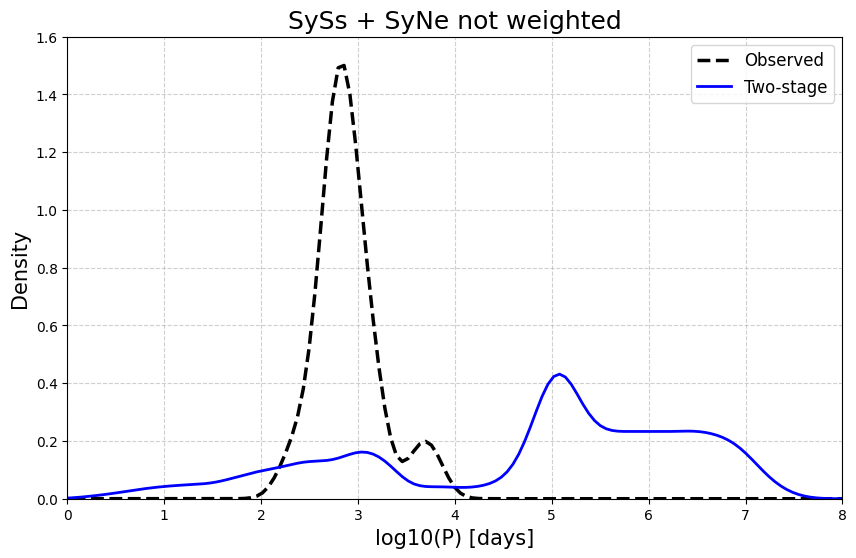

In [40]:
# Start figure
plt.figure(figsize=(10, 6))

# Log-transform observed periods and plot the KDE
plot_kde(log_periods_obs, None , color='k', linestyle='--', linewidth=2.5)

# Log-transform two-stage data and plot the KDE
plot_kde(log_periods_data2Stage, None, color='b', linestyle='-', linewidth=2)

        
# Dummy points with matching linestyle
plt.plot(0, 0, c='k', ls='--', label='Observed', linewidth=2.5) 
plt.plot(0, 0, c='b', ls='-', label='Two-stage', linewidth=2) 

plt.legend(loc='upper right', fontsize=12)  # Place legend in upper right corner

plt.xlim(0, 8)  # Set the limits for x-axis
plt.ylim(0, 1.6)

plt.title('SySs + SyNe not weighted', size = 18)

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.6)  # Add light dashed gridlines


plt.xlabel('log10(P) [days]', size = 15)
plt.ylabel('Density', size = 15)

Plot for all models, not weighted

Text(0, 0.5, 'Density')

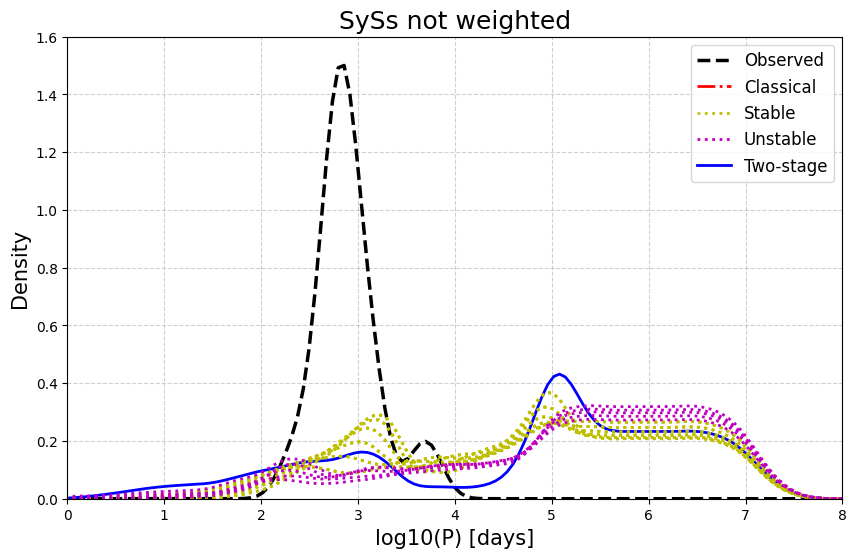

In [41]:
# Start figure
plt.figure(figsize=(10, 6))

# Log-transform observed periods and plot the KDE
plot_kde(log_periods_obs, None , color='k', linestyle='--', linewidth=2.5)

# Log-transform two-stage data and plot the KDE
plot_kde(log_periods_data2Stage, None, color='b', linestyle='-', linewidth=2)


# Loop through dataStables, log-transform and plot histogram
for ind in range(len(log_periods_dataStables)):
    if len(weight_Stables[ind][weight_Stables[ind] > 0]) and list(np.isfinite(weight_Stables[ind])).count(True) > 0:
        plot_kde(log_periods_dataStables[ind][np.isfinite(log_periods_dataStables[ind])], None, color='y', linestyle=':', linewidth=2)  # Plot KDE for stable data

# Loop through dataUnstables, log-transform and plot histogram
for ind in range(len(log_periods_dataUnstables)):
    if len(log_periods_dataUnstables[ind]) > 1: 
        plot_kde(log_periods_dataUnstables[ind], None, color='m', linestyle=':', linewidth=2)  # Plot KDE for stable data
 
"""
# Plot KDE for each dataset in 'dataEnergys' after log-transforming periods
for ind in range(len(log_periods_dataClassics)):
    if len(log_periods_dataClassics[ind]) > 1: 
        plot_kde(log_periods_dataClassics[ind], None, color='r', linestyle='-.', linewidth=2)  # Plot KDE for classical data
"""
        
# Dummy points with matching linestyle
plt.plot(0, 0, c='k', ls='--', label='Observed', linewidth=2.5)  
plt.plot(0, 0, c='r', ls='-.', label='Classical', linewidth=2)  
plt.plot(0, 0, c='y', ls=':', label='Stable', linewidth=2)  
plt.plot(0, 0, c='m', ls=':', label='Unstable', linewidth=2)  
plt.plot(0, 0, c='b', ls='-', label='Two-stage', linewidth=2) 

plt.legend(loc='upper right', fontsize=12)  # Place legend in upper right corner

plt.xlim(0, 8)  # Set the limits for x-axis
plt.ylim(0, 1.6)

plt.title('SySs not weighted', size = 18)

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.6)  # Add light dashed gridlines


plt.xlabel('log10(P) [days]', size = 15)
plt.ylabel('Density', size = 15)

Plot for only the 2stage, weighted

Text(0, 0.5, 'Density')

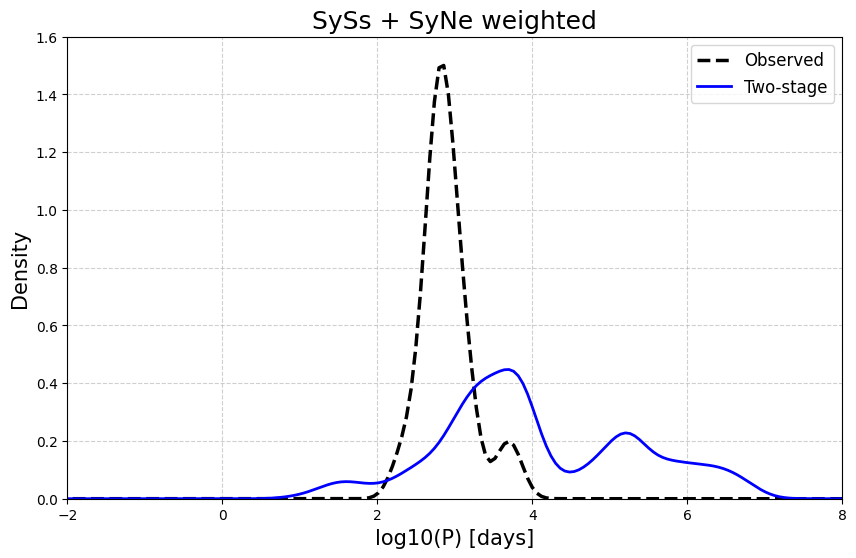

In [42]:
# Start figure
plt.figure(figsize=(10, 6))

# Log-transform observed periods and plot the KDE
plot_kde(log_periods_obs, None , color='k', linestyle='--', linewidth=2.5)

# Log-transform two-stage data and plot the KDE
plot_kde(log_periods_data2Stage, weight_2stage, color='b', linestyle='-', linewidth=2)

        
# Dummy points with matching linestyle
plt.plot(0, 0, c='k', ls='--', label='Observed', linewidth=2.5) 
plt.plot(0, 0, c='b', ls='-', label='Two-stage', linewidth=2) 

plt.legend(loc='upper right', fontsize=12)  # Place legend in upper right corner

plt.xlim(-2, 8)  # Set the limits for x-axis
plt.ylim(0, 1.6)

plt.title('SySs + SyNe weighted', size = 18)

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.6)  # Add light dashed gridlines


plt.xlabel('log10(P) [days]', size = 15)
plt.ylabel('Density', size = 15)

Plot for all models, weighted

Text(0, 0.5, 'Density')

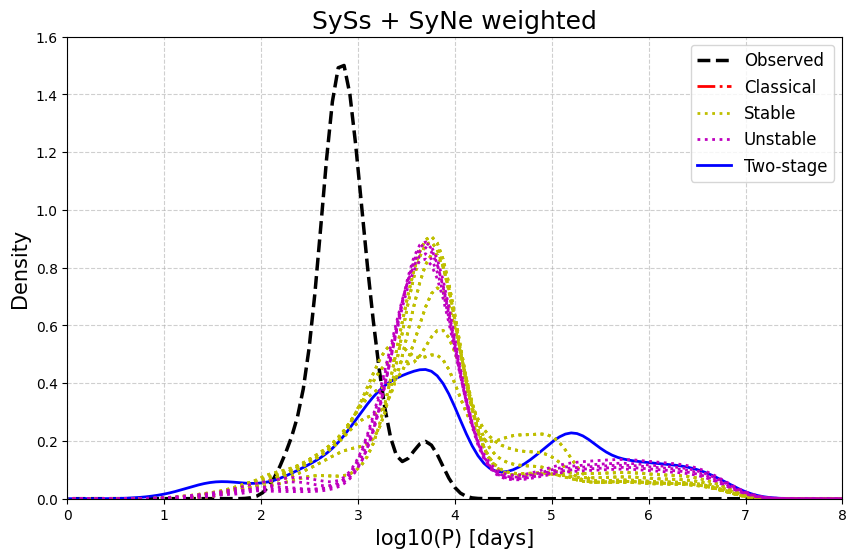

In [43]:
# Start figure
plt.figure(figsize=(10, 6))

# Log-transform observed periods and plot the KDE
plot_kde(log_periods_obs, None , color='k', linestyle='--', linewidth=2.5)

# Log-transform two-stage data and plot the KDE
plot_kde(log_periods_data2Stage, weight_2stage, color='b', linestyle='-', linewidth=2)

# Loop through dataStables, log-transform and plot histogram
for ind in range(len(log_periods_dataStables)):
    if len(weight_Stables[ind][weight_Stables[ind] > 0]) and list(np.isfinite(weight_Stables[ind])).count(True) > 0:
        plot_kde(log_periods_dataStables[ind][np.isfinite(weight_Stables[ind]) & np.isfinite(log_periods_dataStables[ind])], weight_Stables[ind][np.isfinite(weight_Stables[ind]) & np.isfinite(log_periods_dataStables[ind])], color='y', linestyle=':', linewidth=2)  # Plot KDE for stable data

# Loop through dataUnstables, log-transform and plot histogram
for ind in range(len(log_periods_dataUnstables)):
    if len(log_periods_dataUnstables[ind]) > 1: 
        plot_kde(log_periods_dataUnstables[ind], weight_Unstables[ind], color='m', linestyle=':', linewidth=2)  # Plot KDE for stable data
"""
# Plot KDE for each dataset in 'dataEnergys' after log-transforming periods
for ind in range(len(log_periods_dataClassics)):
    if len(log_periods_dataClassics[ind]) > 1: 
        plot_kde(log_periods_dataClassics[ind], weight_Classics[ind], color='r', linestyle='-.', linewidth=2)  # Plot KDE for classical data
"""
        
# Dummy points with matching linestyle
plt.plot(0, 0, c='k', ls='--', label='Observed', linewidth=2.5)  
plt.plot(0, 0, c='r', ls='-.', label='Classical', linewidth=2)  
plt.plot(0, 0, c='y', ls=':', label='Stable', linewidth=2)  
plt.plot(0, 0, c='m', ls=':', label='Unstable', linewidth=2)  
plt.plot(0, 0, c='b', ls='-', label='Two-stage', linewidth=2) 

plt.legend(loc='upper right', fontsize=12)  # Place legend in upper right corner

plt.xlim(0, 8)  # Set the limits for x-axis
plt.ylim(0, 1.6)

plt.title('SySs + SyNe weighted', size = 18)

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.6)  # Add light dashed gridlines


plt.xlabel('log10(P) [days]', size = 15)
plt.ylabel('Density', size = 15)